# **Implémentation d'un modèle de scoring**
___
Une société financière "Prêt à dépenser" propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

Elle souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées.

Le projet a donc pour but de :

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.
___


## 0. MISE EN PLACE

 Nous commençons par mettre en place notre cadre de travail en effectuant les actions suivantes :
 - Importation des librairies et packages Python nécessaires
 - Importation des fonctions utiles implémentées 
 - Chargement du jeu de données

___
### 0.1 Importation des librairies Python nécessaires

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import gc
import time, pickle
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, fbeta_score, f1_score, precision_score, recall_score 
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

from sklearn.feature_selection import RFECV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from joblib import load, dump

import shap

import os

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

___
### 0.2 Importation des fonctions utiles

Par soucis de clarté (lisibilité) et afin d'assurer un meilleur confort de lecture de ce notebook, les fonctions implémentées pour la manipulation des données et la réalisation des graphiques ont été regroupées dans le fichier project_functions.py.

Ces fonctions sont importées via la ligne de code ci-dessous:

In [4]:
from sys import path
path.append("./")

import project_functions as pf

___
### 0.3 Chargement du jeu de données

In [5]:
#Liste des fichiers

PATH="data/"
print("LISTE DES FICHIERS :")
display(os.listdir(PATH))

LISTE DES FICHIERS :


['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv',
 'test_df.csv',
 'train_sample.csv']

In [6]:
#Chargement des données
application_train = pd.read_csv(PATH+"/application_train.csv")
application_test = pd.read_csv(PATH+"/application_test.csv")
bureau = pd.read_csv(PATH+"/bureau.csv")
bureau_balance = pd.read_csv(PATH+"/bureau_balance.csv")
credit_card_balance = pd.read_csv(PATH+"/credit_card_balance.csv")
installments_payments = pd.read_csv(PATH+"/installments_payments.csv")
POS_CASH_balance = pd.read_csv(PATH+"/POS_CASH_balance.csv")
previous_application = pd.read_csv(PATH+"/previous_application.csv")

## 1. DESCRIPTION DU JEU DE DONNEES

___
### 1.1 Apperçu des données

### application_train

In [7]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [8]:
application_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

### application_test

In [9]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [10]:
application_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    NAME_CONTRACT_TYPE            object 
 2    CODE_GENDER                   object 
 3    FLAG_OWN_CAR                  object 
 4    FLAG_OWN_REALTY               object 
 5    CNT_CHILDREN                  int64  
 6    AMT_INCOME_TOTAL              float64
 7    AMT_CREDIT                    float64
 8    AMT_ANNUITY                   float64
 9    AMT_GOODS_PRICE               float64
 10   NAME_TYPE_SUITE               object 
 11   NAME_INCOME_TYPE              object 
 12   NAME_EDUCATION_TYPE           object 
 13   NAME_FAMILY_STATUS            object 
 14   NAME_HOUSING_TYPE             object 
 15   REGION_POPULATION_RELATIVE    float64
 16   DAYS_BIRTH                    int64  
 17   DAYS_EMPLOYED                 int64  
 18   DAYS

### bureau

In [11]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [12]:
bureau.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


### bureau_balance

In [13]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [14]:
bureau_balance.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


### credit_card_balance

In [15]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [16]:
credit_card_balance.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

### installments_payments

In [17]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [18]:
installments_payments.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


### POS_CASH_balance

In [19]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [20]:
POS_CASH_balance.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


### previous_applications

In [21]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
previous_application.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### 1.2 Structure des données

In [23]:
pf.describe_dataset({'Application Train': application_train,
                     'Application Test': application_test, 
                     'Bureau': bureau,
                     'Bureau Balance': bureau_balance,
                     'Credit Card Balance' : credit_card_balance,
                     'Installments Payments': installments_payments,
                     'POS CASH balance': POS_CASH_balance,
                     'Previous Application': previous_application})

Les données se décomposent en 8 fichier(s): 



,Nom du fichier,Nb de lignes,Nb de colonnes,%NaN,%Duplicate
1,Application Train,307511,122,24.40,0.0
2,Application Test,48744,121,23.81,0.0
3,Bureau,1716428,17,13.50,0.0
4,Bureau Balance,27299925,3,0.00,0.0
5,Credit Card Balance,3840312,23,6.65,0.0
6,Installments Payments,13605401,8,0.01,0.0
7,POS CASH balance,10001358,8,0.07,0.0
8,Previous Application,1670214,37,17.98,0.0


Ces fichiers contiennent les informations suivantes :

<table style="width:100%;align:'left'">
  <tr>
    <th>File</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>Application Train</td>
    <td>Main training data. <br>One row represents one loan.
    </td> 
  </tr>
  
  <tr>
    <td>Application Test</td>
    <td>Main testing data. <br> One row represents one loan.</td>
  </tr>
    
  <tr>
    <td>Bureau</td>
    <td>All client's previous credit from other financial institutions <br>
        for clients who have a loan in the sample.
    </td>
  </tr>
 
  <tr>
    <td>Bureau Balance</td>
    <td>Monthly balances of previous credits in bureau. <br>
        The table contains one row for each month of history of <br>
        every previous credit in bureau.
    </td> 
  </tr>

  <tr>
    <td>Credit Card Balance</td>
    <td>Monthly balance snapshots of previous cardit cards of the applicant.<br>
        The table contains one row for each month of history of every <br>
        previous credit in Home Credit (consumer credit and cash loans)<br>
        related to loans in our sample. 
    </td> 
  </tr>

  <tr>
    <td>Installments payments</td>
    <td>Repayment history for the previously disbursed credits related <br>
        to the loans in the sample.<br>
        The table contains :<br>
        - one row for every payment made
        - one row each for missed payment
        One row = one payment of one installment OR one installment <br>
        corresponding to one payment of one previous Home Credit related<br>
        to loans in our sample.
    </td> 
  </tr>
    
  <tr>
    <td>POS CASH balance</td>
    <td>Monthly balance snapshots of previous POS and cash loans that <br>
        the applicant had.<br>
        The table contains one row for each month of history of every <br>
        previous credit in Home Credit (consumer credit and cash loans)<br>
        related to loans in our sample.
    </td> 
  </tr>

  <tr>
    <td>Previous Application</td>
    <td>Previous applications for loans at Home Credit of clients <br>
        who have loans in the application data.<br>
        The table contains one row for each previous application<br>
        related to loans in the sample.
    </td> 
  </tr>
</table>

Ces fichiers sont reliés comme suit :

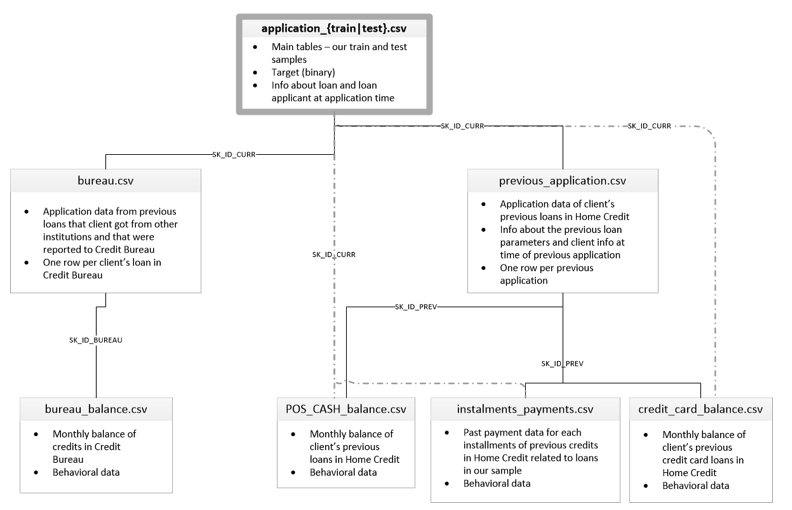

### Documentation

La signification des colonnes de tous les fichiers est décrite dans le fichier `HomeCredit_columns_description.csv`. 

In [24]:
print("DOCUMENTATION :")
pd.set_option("max_colwidth", 400)
description = pd.read_csv(PATH+'/HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
description

DOCUMENTATION :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


___
## 2. ANALYSE EXPLORATOIRE

Nous allons ici explorer plusieurs aspects du jeu de données :
- Les valeurs manquantes
- Les anomalies éventuelles
- La distribution de certaines features d'intérêt
- Les corrélations
___

### 2.1 Valeurs manquantes

### application_train

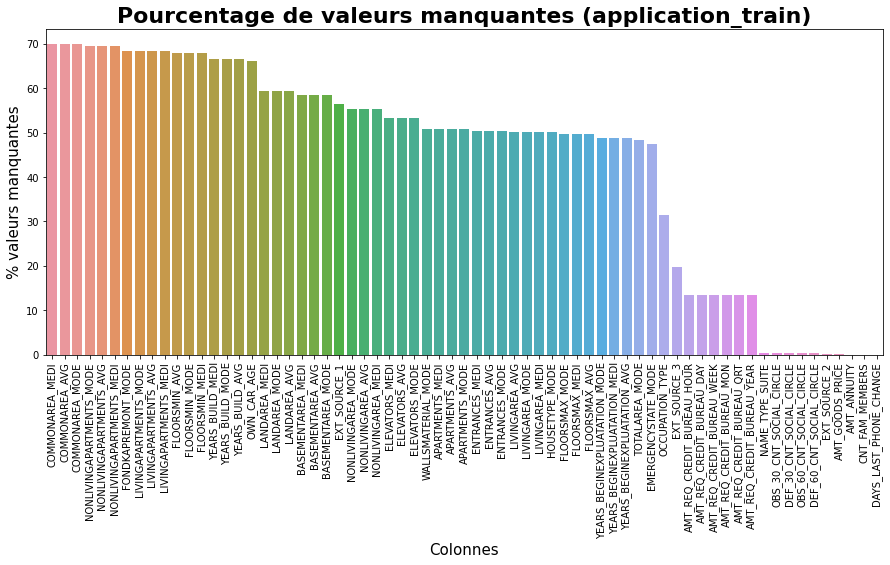

In [25]:
pf.missingdata(application_train, "application_train", 15, 6)

### application_test

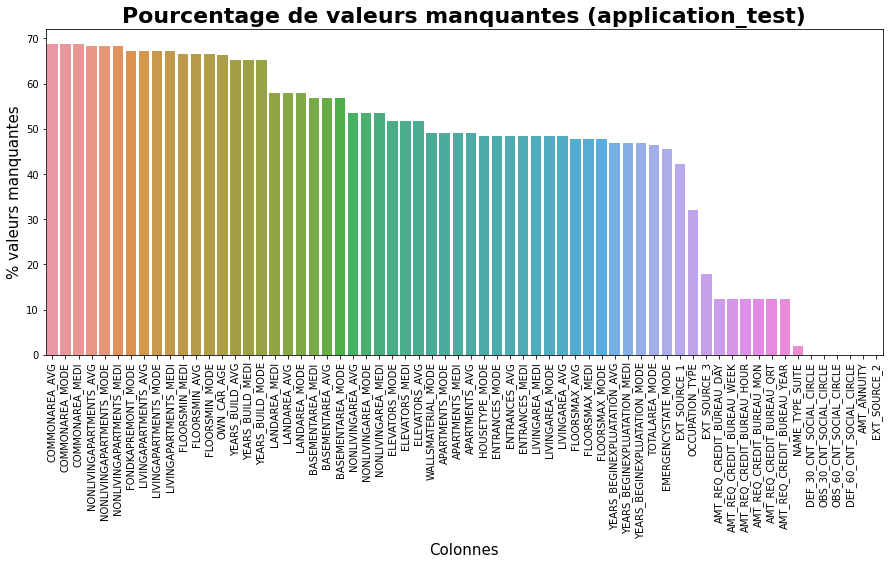

In [26]:
pf.missingdata(application_test, "application_test", 15, 6)

### bureau

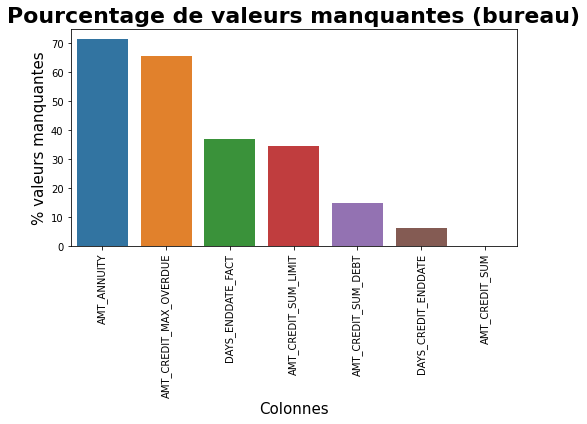

In [27]:
pf.missingdata(bureau, "bureau", 8,4)

### credit_card_balance

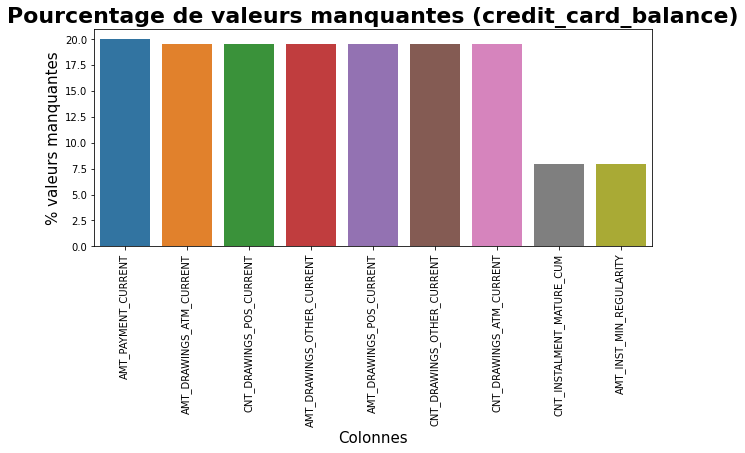

In [28]:
pf.missingdata(credit_card_balance, "credit_card_balance", 10,4)

### installments_payments

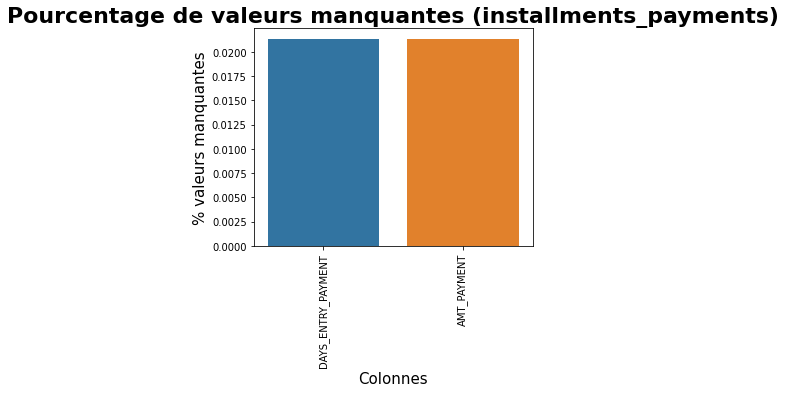

In [29]:
pf.missingdata(installments_payments, "installments_payments", 5,4)

### POS_CASH_balance

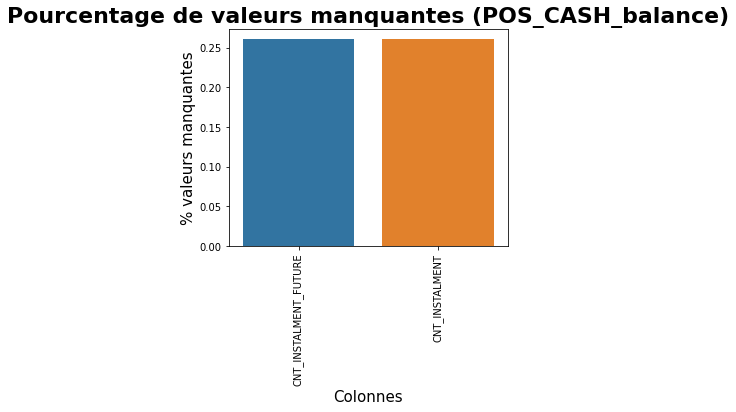

In [30]:
pf.missingdata(POS_CASH_balance, "POS_CASH_balance", 5,4)

### previous_applications

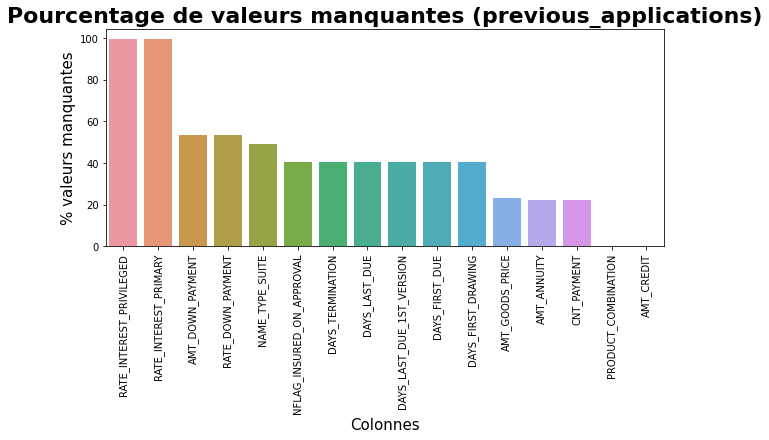

In [31]:
pf.missingdata(previous_application, "previous_applications", 10,4)

### 2.2 Outliers, valeurs atypiques, anormales

### Valeurs aberrantes dans application_train

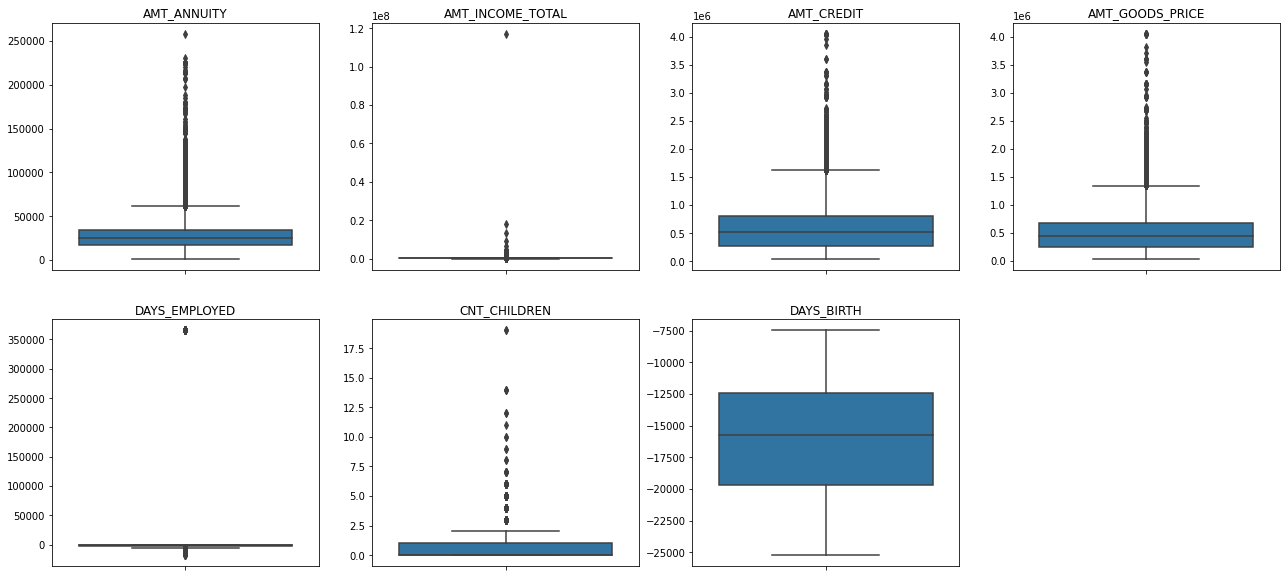

In [32]:
plt.figure(figsize=(22,10))

app_outlier_col_1 = ['AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','DAYS_EMPLOYED']
app_outlier_col_2 = ['CNT_CHILDREN','DAYS_BIRTH']
for i in enumerate(app_outlier_col_1):
    plt.subplot(2,4,i[0]+1)
    sns.boxplot(y=application_train[i[1]])
    plt.title(i[1])
    plt.ylabel("")

for i in enumerate(app_outlier_col_2):
    plt.subplot(2,4,i[0]+6)
    sns.boxplot(y=application_train[i[1]])
    plt.title(i[1])
    plt.ylabel("")

In [33]:
application_train[['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_BIRTH','CNT_CHILDREN','DAYS_EMPLOYED']].describe()

,AMT_ANNUITY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_BIRTH,CNT_CHILDREN,DAYS_EMPLOYED
count,307499.000000,3.075110e+05,3.075110e+05,3.072330e+05,307511.000000,307511.000000,307511.000000
mean,27108.573909,1.687979e+05,5.990260e+05,5.383962e+05,-16036.995067,0.417052,63815.045904
std,14493.737315,2.371231e+05,4.024908e+05,3.694465e+05,4363.988632,0.722121,141275.766519
min,1615.500000,2.565000e+04,4.500000e+04,4.050000e+04,-25229.000000,0.000000,-17912.000000
25%,16524.000000,1.125000e+05,2.700000e+05,2.385000e+05,-19682.000000,0.000000,-2760.000000
50%,24903.000000,1.471500e+05,5.135310e+05,4.500000e+05,-15750.000000,0.000000,-1213.000000
75%,34596.000000,2.025000e+05,8.086500e+05,6.795000e+05,-12413.000000,1.000000,-289.000000
max,258025.500000,1.170000e+08,4.050000e+06,4.050000e+06,-7489.000000,19.000000,365243.000000


- AMT_ANNUITY, AMT_CREDIT, AMT_GOODS_PRICE, CNT_CHILDREN ont un certain nombre de valeurs aberrantes.

- AMT_INCOME_TOTAL a un grand nombre de valeurs aberrantes qui indiquent que quelques demandeurs de prêt ont un revenu élevé par rapport aux autres.

- DAYS_BIRTH n'a pas de valeurs aberrantes, ce qui signifie que les données disponibles sont fiables.

- DAYS_EMPLOYED a des valeurs aberrantes autour de 350000(jours), ce qui représente environ 958 ans, ce qui est impossible, donc c'est certainement une entrée incorrecte.

### Valeurs aberrantes dans previous_applications

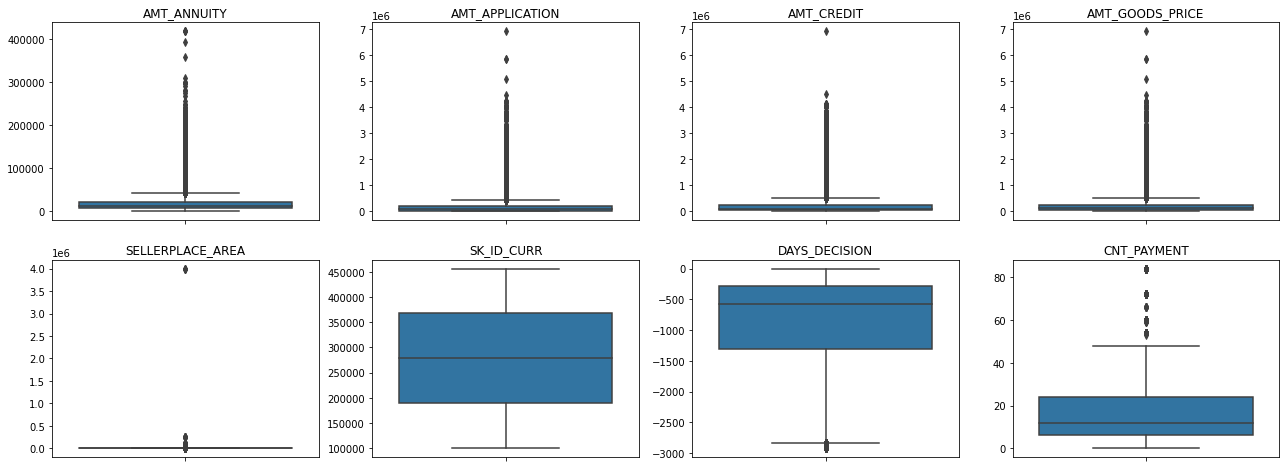

In [34]:
plt.figure(figsize=(22,8))

prev_outlier_col_1 = ['AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE','SELLERPLACE_AREA']
prev_outlier_col_2 = ['SK_ID_CURR','DAYS_DECISION','CNT_PAYMENT']
for i in enumerate(prev_outlier_col_1):
    plt.subplot(2,4,i[0]+1)
    sns.boxplot(y=previous_application[i[1]])
    plt.title(i[1])
    plt.ylabel("")

for i in enumerate(prev_outlier_col_2):
    plt.subplot(2,4,i[0]+6)
    sns.boxplot(y=previous_application[i[1]])
    plt.title(i[1])
    plt.ylabel("") 

In [35]:
previous_application[['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'SELLERPLACE_AREA','CNT_PAYMENT','DAYS_DECISION']].describe()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_DECISION
count,1.297979e+06,1.670214e+06,1.670213e+06,1.284699e+06,1.670214e+06,1.297984e+06,1.670214e+06
mean,1.595512e+04,1.752339e+05,1.961140e+05,2.278473e+05,3.139511e+02,1.605408e+01,-8.806797e+02
std,1.478214e+04,2.927798e+05,3.185746e+05,3.153966e+05,7.127443e+03,1.456729e+01,7.790997e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-2.922000e+03
25%,6.321780e+03,1.872000e+04,2.416050e+04,5.084100e+04,-1.000000e+00,6.000000e+00,-1.300000e+03
50%,1.125000e+04,7.104600e+04,8.054100e+04,1.123200e+05,3.000000e+00,1.200000e+01,-5.810000e+02
75%,2.065842e+04,1.803600e+05,2.164185e+05,2.340000e+05,8.200000e+01,2.400000e+01,-2.800000e+02
max,4.180581e+05,6.905160e+06,6.905160e+06,6.905160e+06,4.000000e+06,8.400000e+01,-1.000000e+00


- AMT_ANNUITY, AMT_APPLICATION, AMT_CREDIT, AMT_GOODS_PRICE, SELLERPLACE_AREA ont un nombre important de valeurs aberrantes.

- CNT_PAYMENT a quelques valeurs aberrantes.

- SK_ID_CURR est une colonne d'identification et donc aucune valeur aberrante.

- DAYS_DECISION a un petit nombre de valeurs aberrantes, ce qui indique que les décisions relatives aux demandes précédentes ont été prises il y a longtemps.

### 2.3 Distribution de certaines features d'intérêt

### `TARGET`: statut de remboursement du prêt

- la valeur 0 signifie que le prêt est remboursé
- la valeur 1 signifie que le prêt n'est pas remboursé.

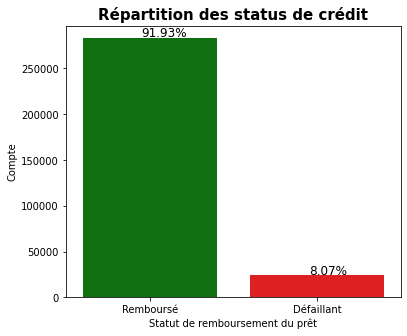

In [36]:
Imbalance = application_train["TARGET"].value_counts().reset_index()

plt.figure(figsize=(6,5))
x= ['Remboursé','Défaillant']
ax = sns.barplot(x,"TARGET",data = Imbalance,palette= ['g','r'])

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/len(application_train.TARGET))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() * 1.01
    ax.annotate(percentage, (x, y), fontsize=12)

plt.xlabel("Statut de remboursement du prêt")
plt.ylabel("Compte")
plt.title("Répartition des status de crédit",fontsize=15, fontweight='bold')
plt.show()


- La majorité des clients remboursent leur crédit.
- cette variable étant la variable d'intérêt principale, nous seront en face d'un problème de classification binaire déséquilibrée

### `NAME_CONTRACT_TYPE` : type de contrat

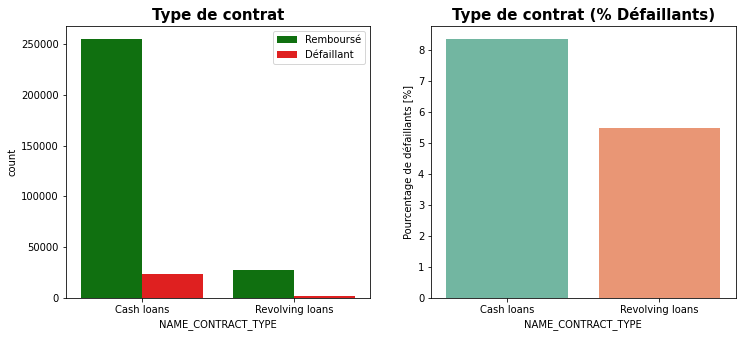

In [37]:
# Vérification du type de contrat en fonction 
# de l'état de remboursement du prêt

pf.univariate_categorical(application_train, 'NAME_CONTRACT_TYPE', "Type de contrat")

les prêts renouvelables ne représentent qu'une petite fraction (10 %) du nombre total de prêts ; dans le même temps, un plus grand nombre de prêts renouvelables, par rapport à leur fréquence, ne sont pas remboursés.

### `CODE_GENDER` : genre

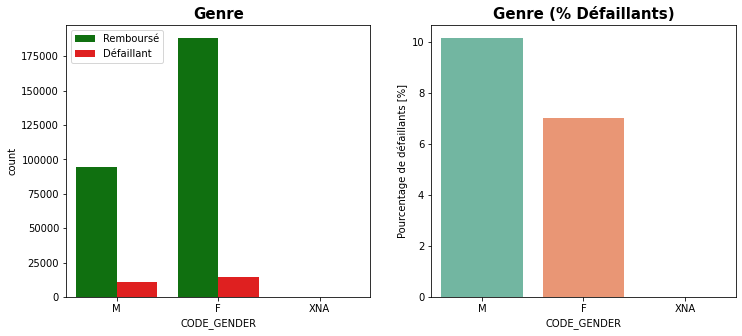

In [38]:
# Distribution du genre en fonction 
# de l'état de remboursement du prêt

pf.univariate_categorical(application_train, 'CODE_GENDER', "Genre")

Le nombre de clients féminins est presque le double du nombre de clients masculins. Sur la base du pourcentage de crédits en défaut, les hommes ont plus de chances de ne pas rembourser leurs prêts (~ 10 %), par rapport aux femmes (~ 7 %)

### `FLAG_OWN_CAR` : indication sur la possession d'un véhicule

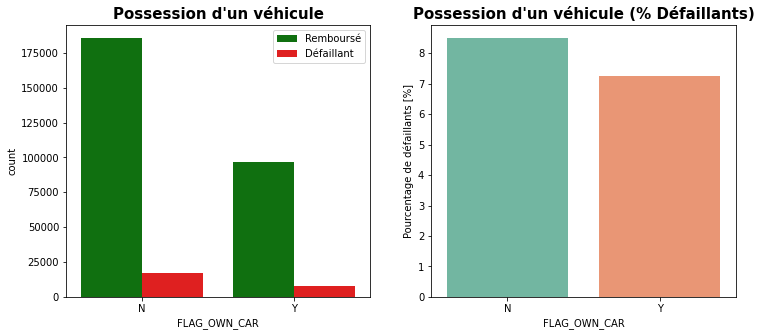

In [39]:
# Analyse de l'impact de la possession d'un véhicule  
# sur de l'état de remboursement du prêt

pf.univariate_categorical(application_train, 'FLAG_OWN_CAR', "Possession d'un véhicule")

Les clients qui possèdent une voiture sont la moitié en nombre des clients qui ne possèdent pas de voiture. Mais sur la base du pourcentage de défaut, il n'y a pas de corrélation entre la possession d'une voiture et le remboursement du prêt car dans les deux cas, le pourcentage de défaut est presque le même.

### `FLAG_OWN_REALTY` : indication sur la possession d'un bien immobilier

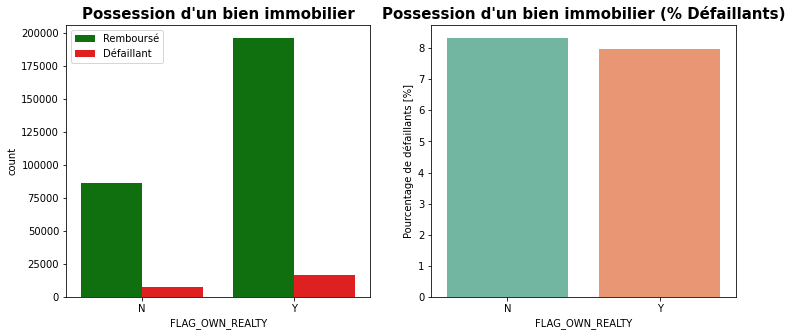

In [40]:
# Analyse de l'impact de la possession d'un bien immobilier  
# sur de l'état de remboursement du prêt

pf.univariate_categorical(application_train, 'FLAG_OWN_REALTY', "Possession d'un bien immobilier")

Les clients qui possèdent des biens immobiliers sont plus du double de ceux qui ne sont pas propriétaires. Mais le taux de défaut des deux catégories est à peu près le même (~8%). Ainsi, il n'y a pas de corrélation entre la possession d'un bien immobilier et le défaut de paiement du prêt.

### `NAME_FAMILY_STATUS` : statut familial

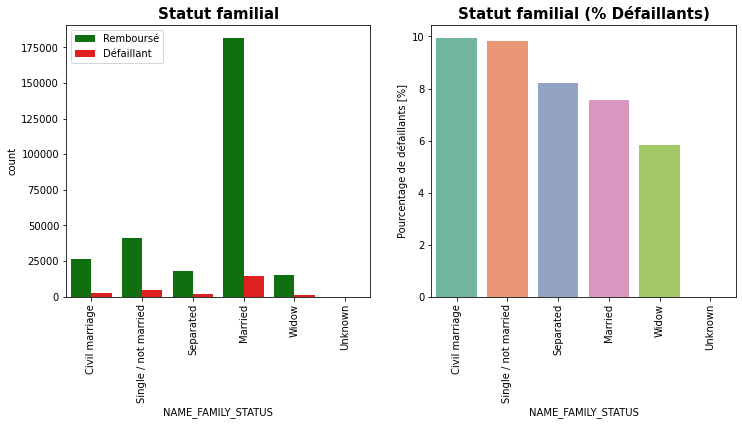

In [41]:
# Analyse de l'impact du statut familial
# sur de l'état de remboursement du prêt

pf.univariate_categorical(application_train, 'NAME_FAMILY_STATUS', "Statut familial", False,True,True)

- La plupart des personnes qui ont contracté un prêt sont mariées, suivies par les célibataires/non mariés et le mariage civil
- En termes de pourcentage de non-remboursement de prêt, le mariage civil a le pourcentage le plus élevé de non-remboursement (10 %), le statut de veuf(ve) eyant le plus faible taux de non-remboursement (l'exception étant inconnue).

### `NAME_EDUCATION_TYPE` : niveau d'éducation

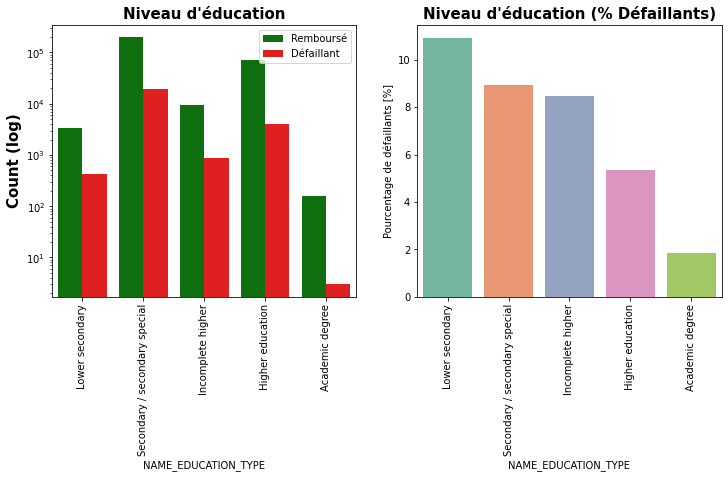

In [42]:
# Analyse de l'impact du niveau d'éducation
# sur de l'état de remboursement du prêt

pf.univariate_categorical(application_train, 'NAME_EDUCATION_TYPE', "Niveau d'éducation", True,True,True)

- La majorité des clients ont une éducation de niveau secondaire, suivis des clients avec une éducation supérieure. Un très petit nombre d'emprunteur possède un diplôme universitaire.

- La catégorie du premier cycle du secondaire, bien que rare, a le taux le plus élevé de non-remboursement du prêt (11%). Les personnes ayant un diplôme universitaire ont un taux de non-remboursement inférieur à 2%.

### `NAME_INCOME_TYPE` : type de revenu

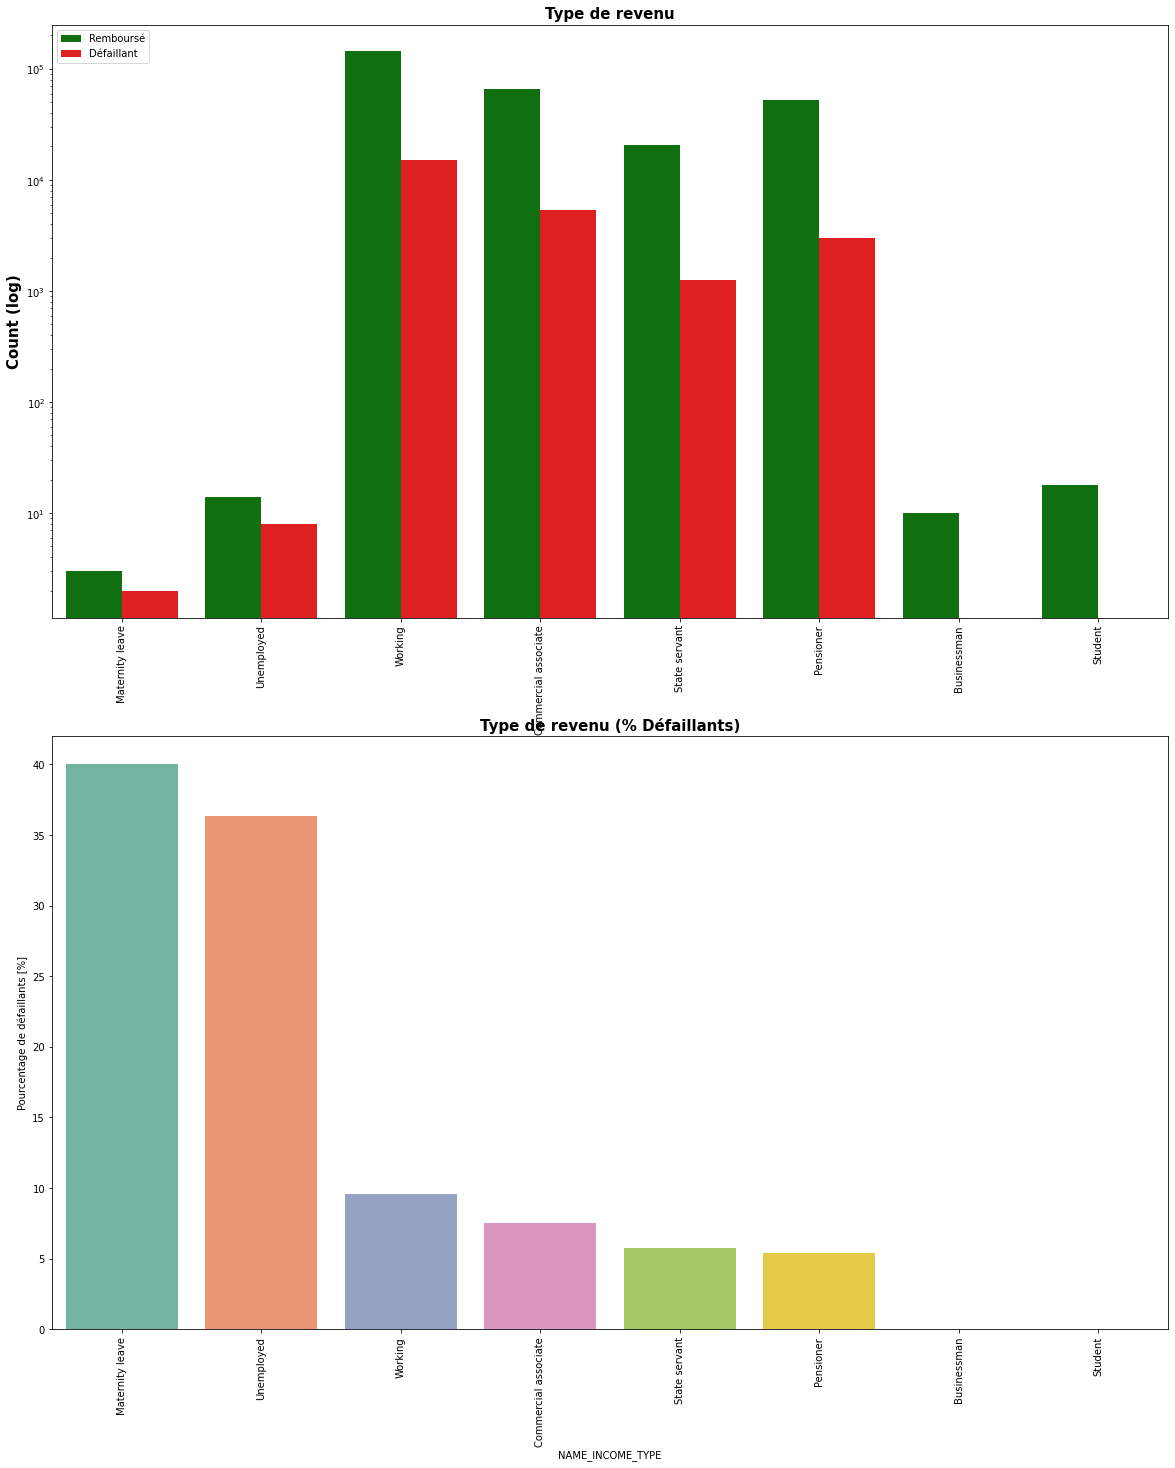

In [43]:
# Analyse de l'impact du type de revenu
# sur de l'état de remboursement du prêt

pf.univariate_categorical(application_train, 'NAME_INCOME_TYPE', "Type de revenu", True,True,False)

- La plupart des demandeurs de prêts ont pour type de revenu le travail, suivi par les associés commerciaux, les retraités et les fonctionnaires.
- Les demandeurs ayant un revenu de type congé de maternité ont un taux de non-retour de près de 40 %, suivis par les chômeurs (37 %). Les autres types de revenus se situent en dessous de la moyenne de 10% de non remboursement des prêts.
- Les étudiants et les hommes d'affaires, bien que moins nombreux, n'ont pas de cas de défaut de paiement. Ces deux catégories sont donc les plus sûres pour l'octroi de prêts.

### `OCCUPATION_TYPE` : type de profession

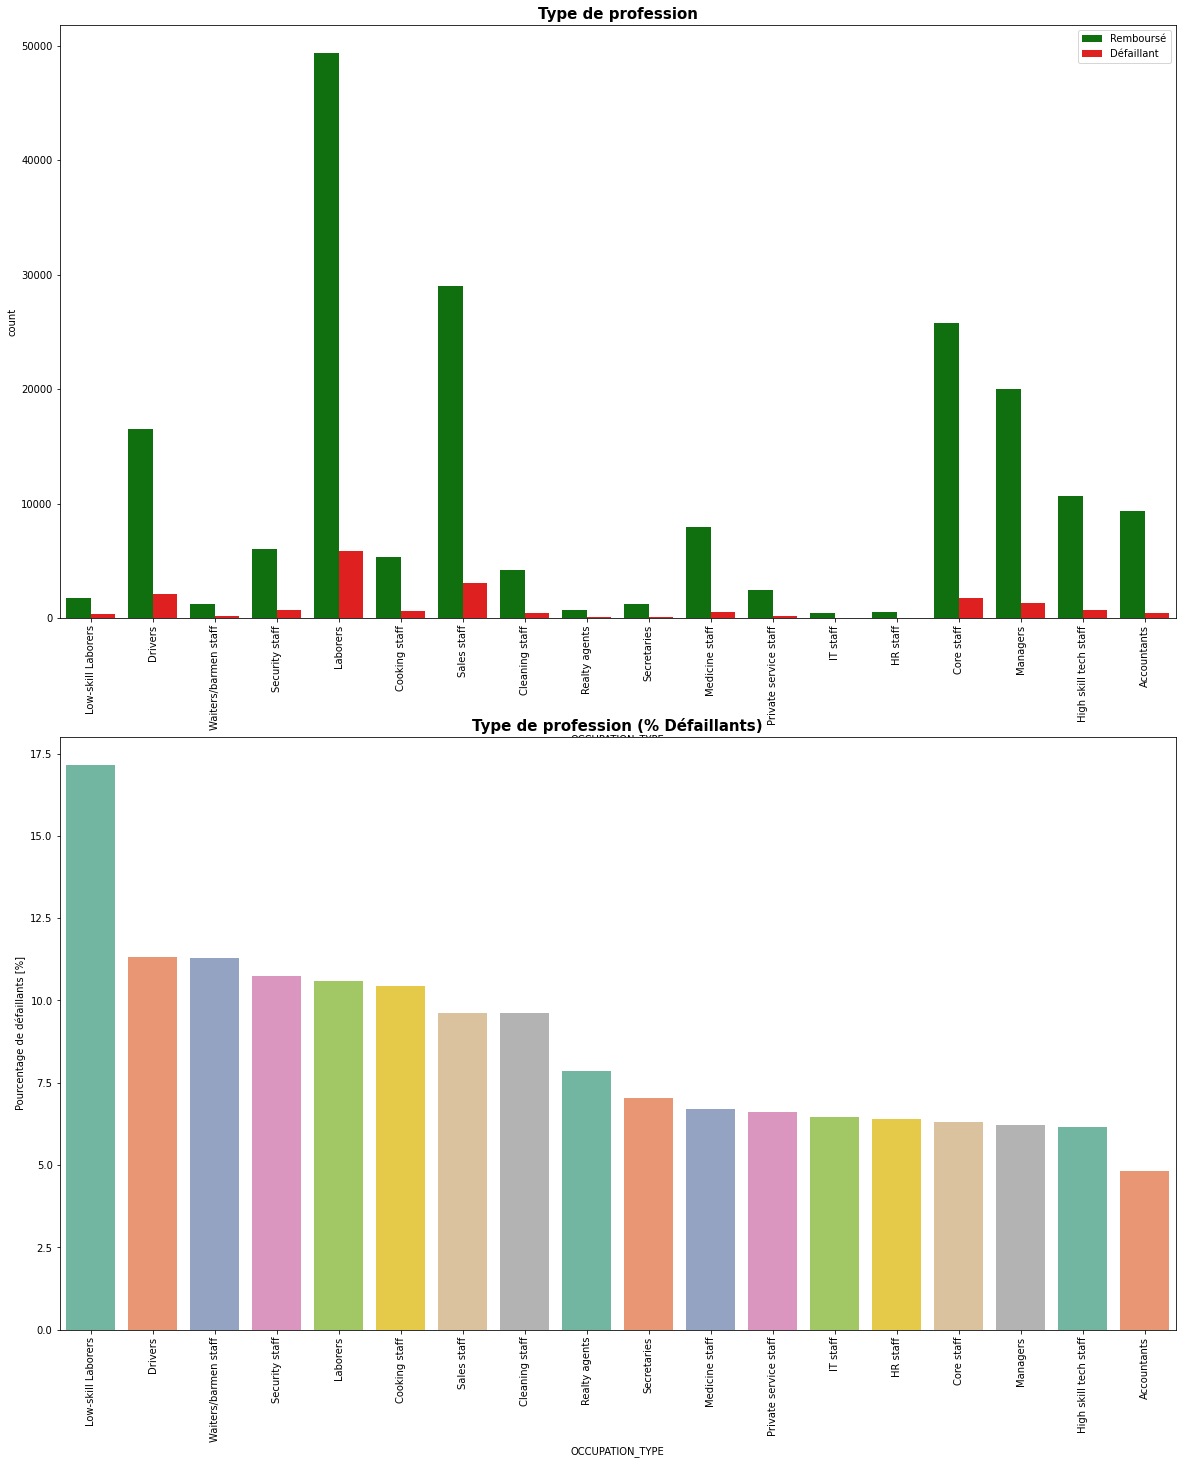

In [44]:
# Analyse de l'impact du type de profession
# sur de l'état de remboursement du prêt

pf.univariate_categorical(application_train, 'OCCUPATION_TYPE', "Type de profession", False,True,False)

- La plupart des prêts sont contractés par des ouvriers, suivis par le personnel de vente. Les informaticiens sont ceux qui empruntent le moins.
- La catégorie présentant le pourcentage le plus élevé de prêts non remboursés est celle des ouvriers peu qualifiés (plus de 17%), suivie des chauffeurs et des serveurs/barmen, du personnel de sécurité, des ouvriers et du personnel de cuisine.

### `CNT_CHILDREN` : Nombre d'enfants

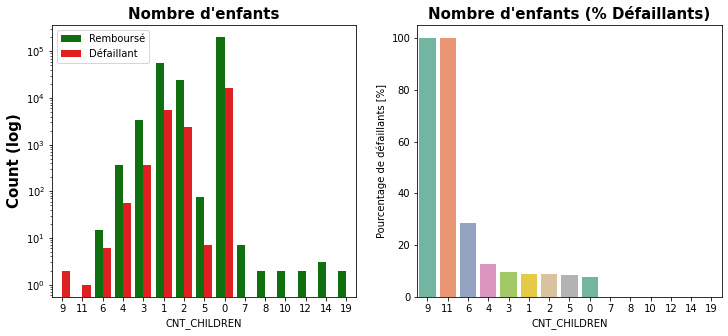

In [45]:
pf.univariate_categorical(application_train, 'CNT_CHILDREN', "Nombre d'enfants", True)

- La plupart des demandeurs n'ont pas d'enfants

- Très peu de clients ont plus de 3 enfants.

- Les clients qui ont plus de 4 enfants ont un taux de défaillance très élevé, ceux ayant  9 et 11 enfants présentant un taux de défaillance de 100%.

### `DAYS_BIRTH` (`AGE_GROUP`)  : Age

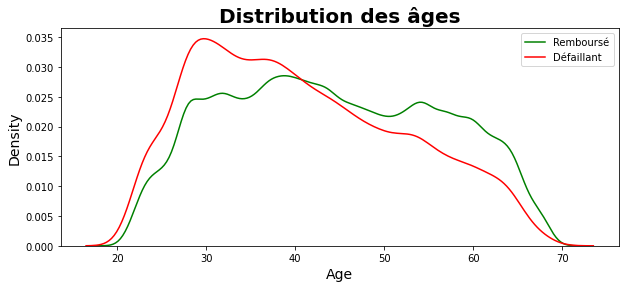

In [46]:
# Analyse de l'impact de l'âge
# sur de l'état de remboursement du prêt

plt.figure(figsize = (10, 4))
sns.kdeplot(application_train[application_train['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'Remboursé', color='g')
sns.kdeplot(application_train[application_train['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'Défaillant', color='r')

plt.legend()
plt.xlabel('Age',fontsize='14')
plt.ylabel('Density',fontsize='14')
plt.title('Distribution des âges', fontsize='20', fontweight='bold')
plt.show()

In [47]:
# Creating bins for Age
applicationDF = application_train.copy()

applicationDF['AGE'] = applicationDF['DAYS_BIRTH'] // -365
bins = [0,20,30,40,50,100]
slots = ['0-20','20-30','30-40','40-50','50 above']

applicationDF['AGE_GROUP']=pd.cut(applicationDF['AGE'],bins=bins,labels=slots)

In [48]:
applicationDF['AGE_GROUP'].value_counts(normalize=True)*100

50 above    31.604398
30-40       27.028952
40-50       24.194582
20-30       17.171743
0-20         0.000325
Name: AGE_GROUP, dtype: float64

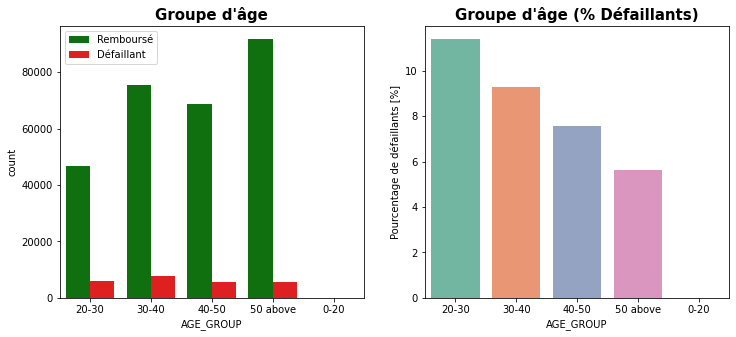

In [49]:
pf.univariate_categorical(applicationDF, 'AGE_GROUP', "Groupe d'âge", False,False,True)

- Les personnes de la tranche d'âge 20-40 ans ont une probabilité plus élevée de défaillance.

- Les personnes âgées de plus de 50 ans ont une faible probabilité de défaillance.

### `DAYS_EMPLOYED` (`EMPLOYMENT_YEAR`)  : nombre de jours/d'années d'emploi

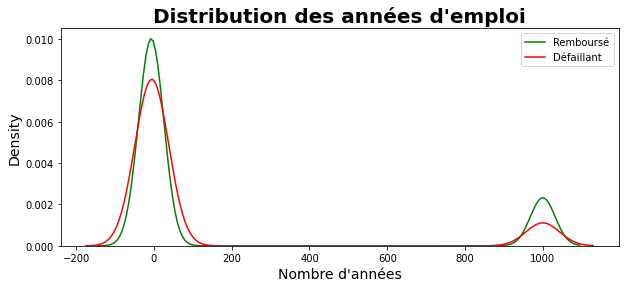

In [50]:
# Analyse de l'impact du nombre de jours/d'années d'emploi
# sur de l'état de remboursement du prêt

plt.figure(figsize = (10, 4))
sns.kdeplot(application_train[application_train['TARGET'] == 0]['DAYS_EMPLOYED'] // 365, label = 'Remboursé', color='g')
sns.kdeplot(application_train[application_train['TARGET'] == 1]['DAYS_EMPLOYED'] // 365, label = 'Défaillant', color='r')

plt.legend()
plt.xlabel("Nombre d'années",fontsize='14')
plt.ylabel('Density',fontsize='14')
plt.title("Distribution des années d'emploi", fontsize='20', fontweight='bold')
plt.show()

On observe une information abbérante: un ou plusieurs individus ayant travaillé 1000 ans 

In [51]:
# Creating bins for Employement Time
applicationDF['YEARS_EMPLOYED'] = applicationDF['DAYS_EMPLOYED'] // -365
bins = [0,5,10,20,30,40,50,60,150]
slots = ['0-5','5-10','10-20','20-30','30-40','40-50','50-60','60 above']

applicationDF['EMPLOYMENT_YEAR']=pd.cut(applicationDF['YEARS_EMPLOYED'],bins=bins,labels=slots)

In [52]:
#checking the binning of data and % of data in each category
applicationDF['EMPLOYMENT_YEAR'].value_counts(normalize=True)*100

0-5         55.582363
5-10        24.966441
10-20       14.564315
20-30        3.750117
30-40        1.058720
40-50        0.078044
50-60        0.000000
60 above     0.000000
Name: EMPLOYMENT_YEAR, dtype: float64

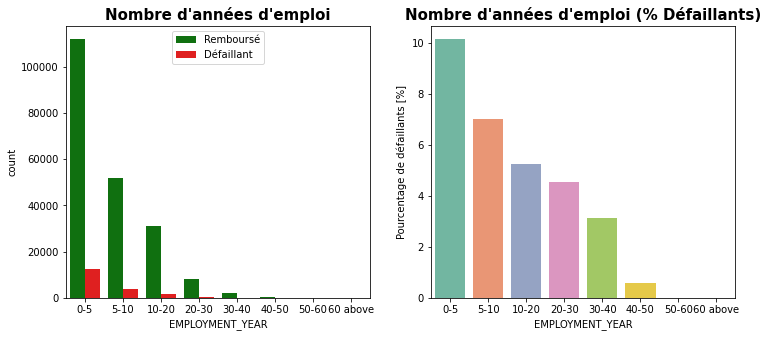

In [53]:
pf.univariate_categorical(applicationDF, 'EMPLOYMENT_YEAR', "Nombre d'années d'emploi", False,False,True)

- La majorité des demandeurs ont été employés entre 0 et 5 ans. Le taux de défaillance de ce groupe est également le plus élevé, soit 10 %.

- Avec l'augmentation de l'année d'emploi, le taux de défaillance diminue progressivement, les personnes ayant plus de 40 ans d'expérience ayant un taux de défaillance inférieur à 1%.

### `AMT_CREDIT` (`AMT_CREDIT_RANGE`)  : Montant du crédit du prêt

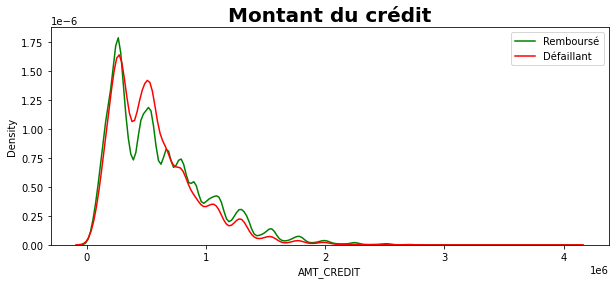

In [54]:
# Analyse de l'impact du montant du crédit
# sur de l'état de remboursement du prêt
pf.plot_distribution(application_train,'AMT_CREDIT', "Montant du crédit")

In [55]:
# Creating bins for Credit amount
applicationDF['AMT_CREDIT']=applicationDF['AMT_CREDIT']/100000

bins = [0,1,2,3,4,5,6,7,8,9,10,100]
slots = ['0-100K','100K-200K', '200k-300k','300k-400k','400k-500k','500k-600k','600k-700k','700k-800k',
       '800k-900k','900k-1M', '1M Above']

applicationDF['AMT_CREDIT_RANGE']=pd.cut(applicationDF['AMT_CREDIT'],bins=bins,labels=slots)

In [56]:
#checking the binning of data and % of data in each category
applicationDF['AMT_CREDIT_RANGE'].value_counts(normalize=True)*100

200k-300k    17.824728
1M Above     16.254703
500k-600k    11.131960
400k-500k    10.418489
100K-200K     9.801275
300k-400k     8.564897
600k-700k     7.820533
800k-900k     7.086576
700k-800k     6.241403
900k-1M       2.902986
0-100K        1.952450
Name: AMT_CREDIT_RANGE, dtype: float64

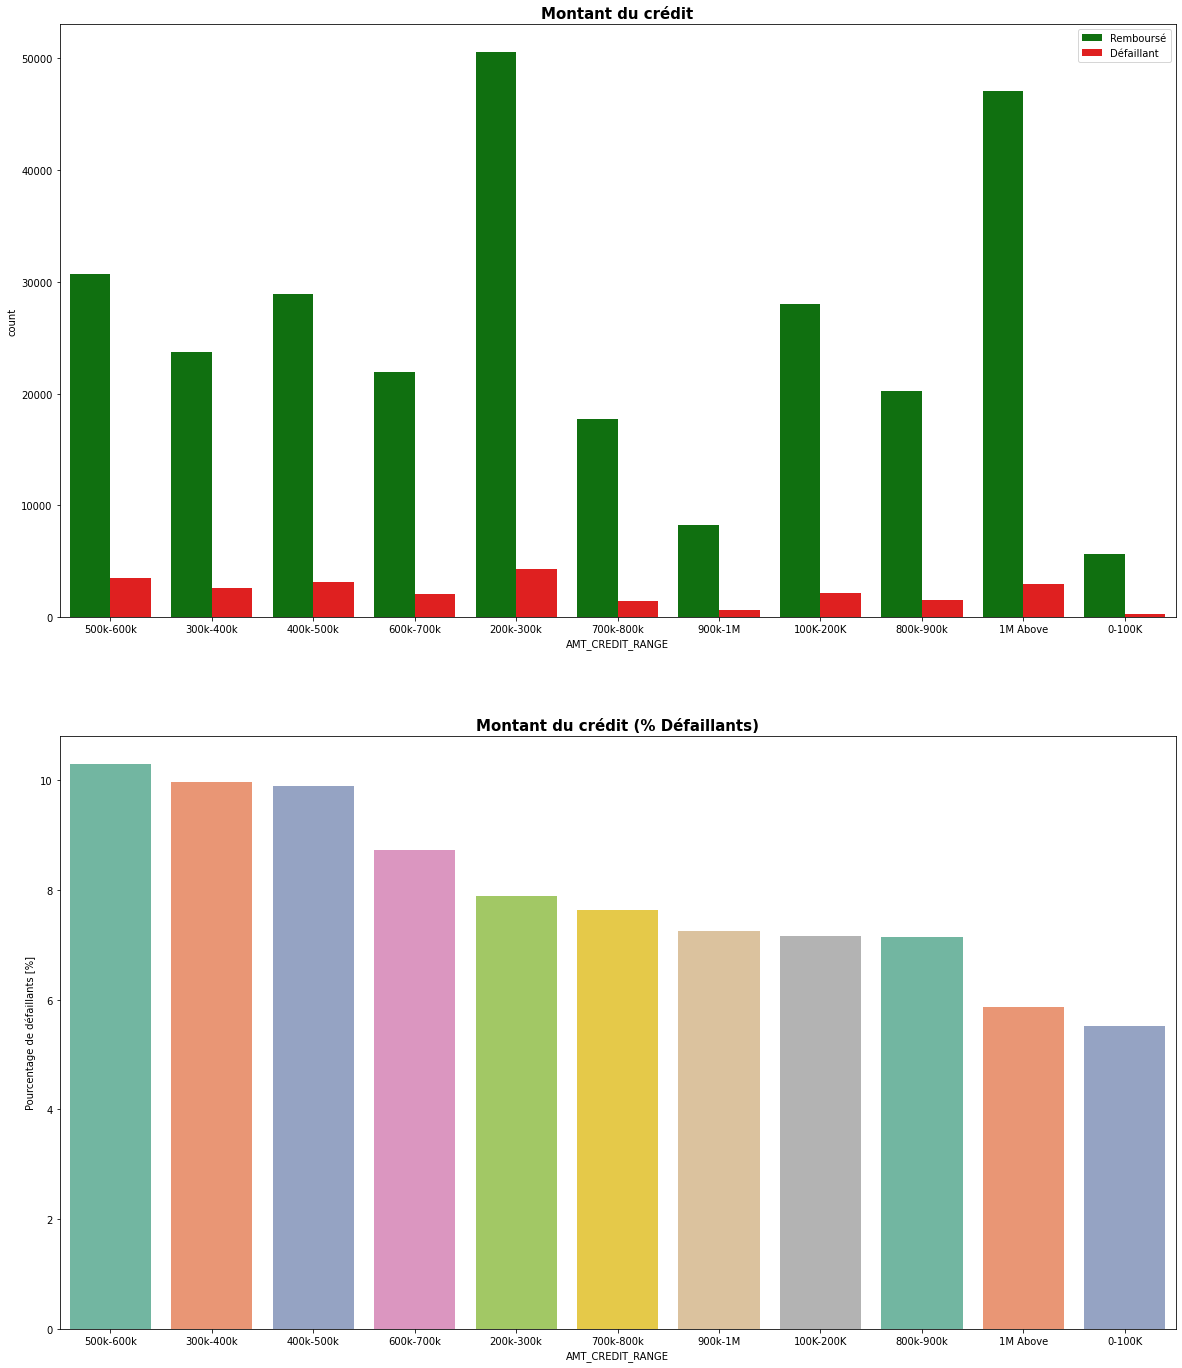

In [57]:
pf.univariate_categorical(applicationDF, 'AMT_CREDIT_RANGE', "Montant du crédit",False,False,False)

- Plus de 80 % des prêts accordés sont d'un montant inférieur à 900 000 euros.

- Les personnes qui obtiennent des prêts de 300 à 600 000 euros ont tendance à ne pas rembourser leurs emprunts plus souvent que les autres.

### `AMT_INCOME_TOTAL` (`AMT_INCOME_RANGE`)  : Revenu total

In [58]:
# Analyse de l'impact du montant des revenus du client
# sur de l'état de remboursement du prêt

# Creating bins for income amount
applicationDF['AMT_INCOME_TOTAL']=applicationDF['AMT_INCOME_TOTAL']/100000

bins = [0,1,2,3,4,5,6,7,8,9,10,11]
slot = ['0-100K','100K-200K', '200k-300k','300k-400k','400k-500k','500k-600k','600k-700k','700k-800k','800k-900k','900k-1M', '1M Above']

applicationDF['AMT_INCOME_RANGE']=pd.cut(applicationDF['AMT_INCOME_TOTAL'],bins,labels=slot)

In [59]:
applicationDF['AMT_INCOME_RANGE'].value_counts(normalize=True)*100

100K-200K    50.735000
200k-300k    21.210691
0-100K       20.729695
300k-400k     4.776116
400k-500k     1.744669
500k-600k     0.356354
600k-700k     0.282805
800k-900k     0.096980
700k-800k     0.052721
900k-1M       0.009112
1M Above      0.005858
Name: AMT_INCOME_RANGE, dtype: float64

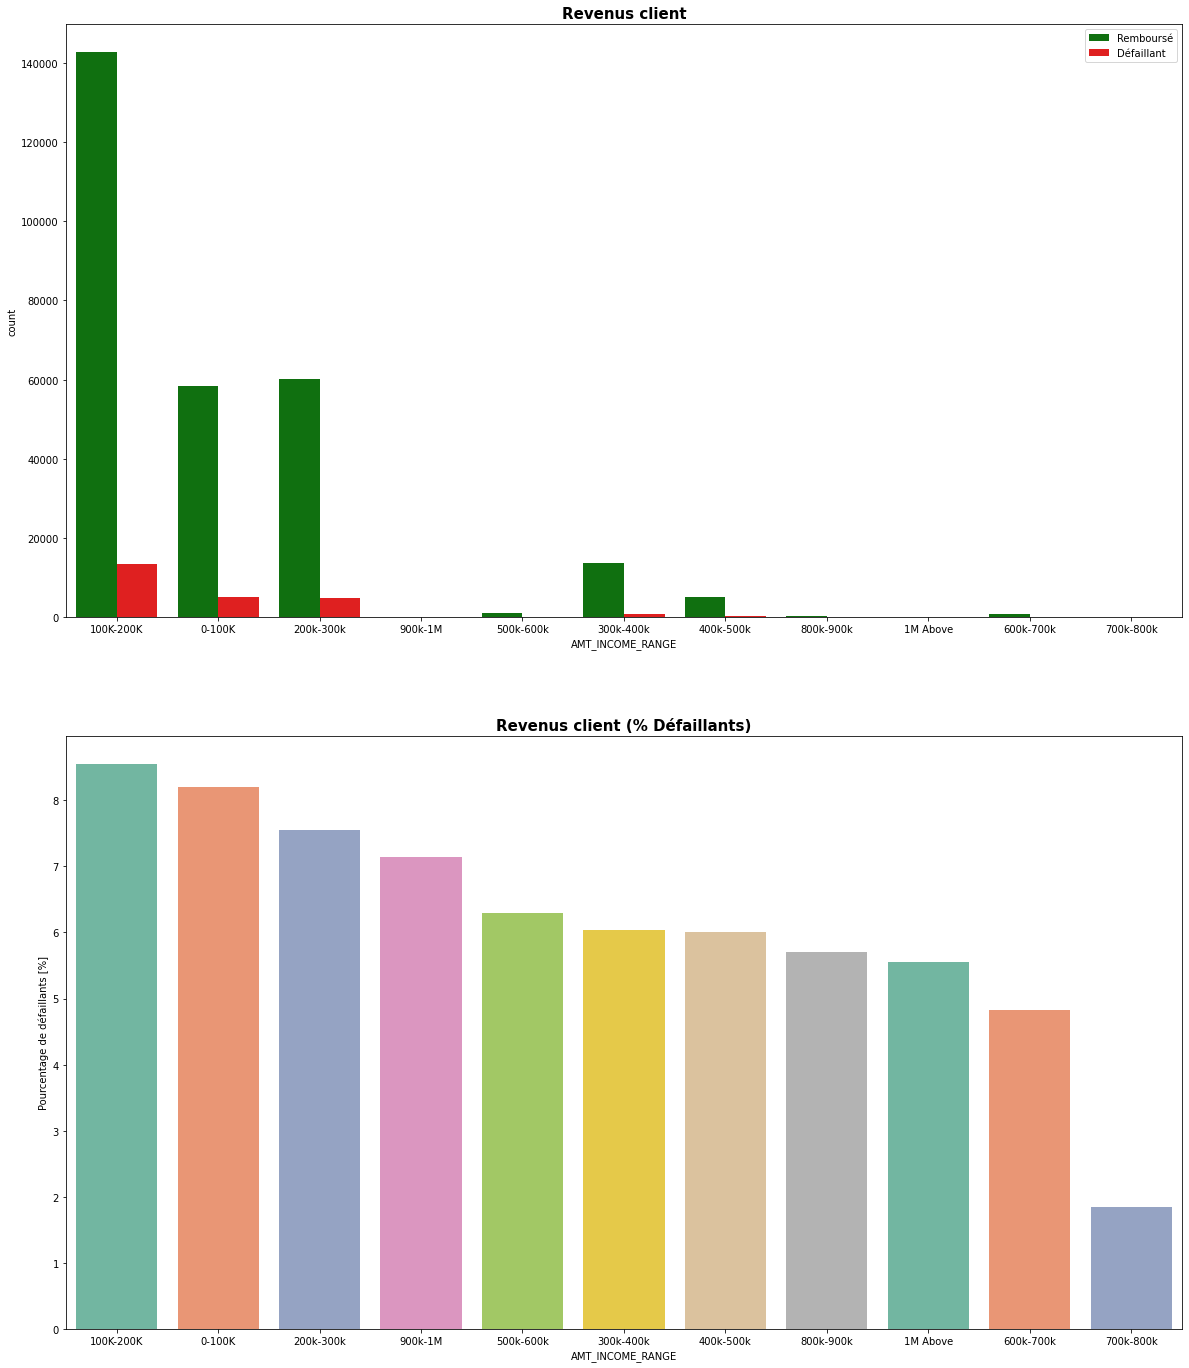

In [60]:
pf.univariate_categorical(applicationDF, 'AMT_INCOME_RANGE', "Revenus client",False,False,False)

- 90 % des demandes ont un revenu total inférieur à 300 000 euros.

- Les demandes dont le revenu est inférieur à 300 000 ont une forte probabilité de défaillance.

- Les demandeurs dont les revenus sont supérieurs à 700 000 ont moins de chances de se retrouver en défaut de paiement.

### 2.4 Corrélations

L'analyse peut continuer par une étape de traitement des corrélations entre les caractéristiques et la Target. L'idée est de calculer le coefficient de corrélation de Pearson entre chaque variable et la Target. Cette étape permet d'avoir un aperçu des relations possibles entre les variables.

In [61]:
#Display correlations
print('15 top correlations positives avec TARGET:\n\n', application_train.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('15 top correlations négatives avec TARGET:\n\n', application_train.corr()['TARGET'].sort_values().head(15))

15 top correlations positives avec TARGET:

 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
--------------------------
15 top correlations négatives avec TARGET:

 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE      

Les 3 variables présentant les corrélations négatives les plus fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Selon la documentation, ces caractéristiques représentent un "score normalisé provenant d'une source de données externe". Je ne suis pas sûr de ce que cela signifie exactement, mais il peut s'agir d'une sorte de notation cumulative réalisée à partir de nombreuses sources de données.

Jetons un coup d'œil à ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques EXT_SOURCE avec la cible et entre elles.

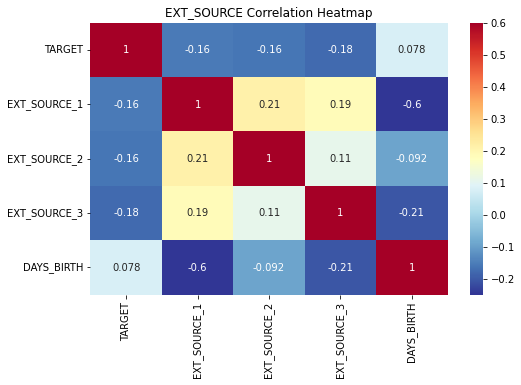

In [62]:
#Heatmap of correlations
plt.figure(figsize = (8,5))
sns.heatmap(application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')
plt.show()

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de la EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Ensuite, nous pouvons examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.


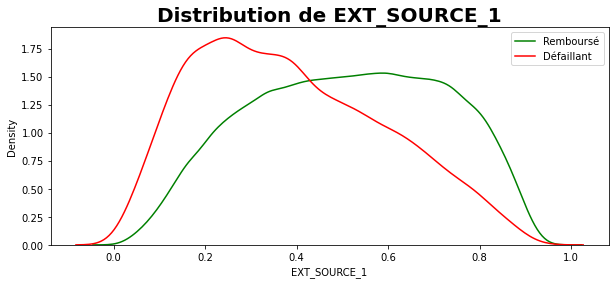

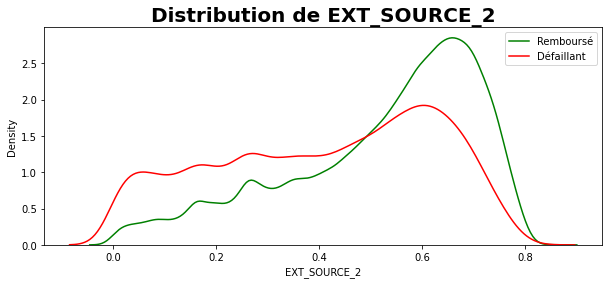

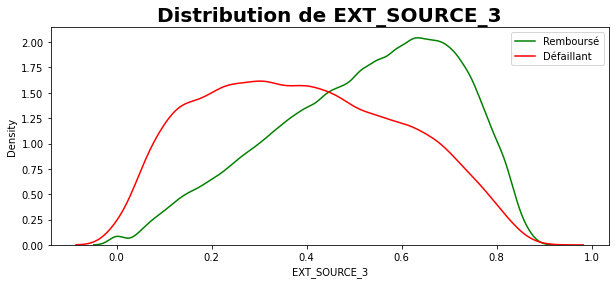

In [63]:
pf.plot_distribution(application_train,'EXT_SOURCE_1', "Distribution de EXT_SOURCE_1")
pf.plot_distribution(application_train,'EXT_SOURCE_2', "Distribution de EXT_SOURCE_2")
pf.plot_distribution(application_train,'EXT_SOURCE_3', "Distribution de EXT_SOURCE_3")

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte. En fait, elles sont toutes considérées comme très faibles, mais ces variables seront tout de même utiles à un modèle d'apprentissage automatique pour prédire si un demandeur remboursera ou non un prêt à temps

In [64]:
# On libère la mémoire après l'analyse exploratoire
del application_train
gc.collect()
del application_test
gc.collect()
del bureau
gc.collect()
del bureau_balance
gc.collect()
del credit_card_balance
gc.collect()
del installments_payments
gc.collect()
del POS_CASH_balance
gc.collect()
del previous_application
gc.collect()

0

___
## 3. FEATURES ENGINEERING

Cette partie est entierement inspirée du notebook kaggle suivant https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/

**Spécifications**

- Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
- Little feature selection is done and overfitting might be a problem since many features are related.
- The following key ideas were used:
    * Divide or subtract important features to get rates (like annuity and income)
    * In Bureau Data: create specific features for Active credits and Closed credits
    * In Previous Applications: create specific features for Approved and Refused applications
    * Modularity: one function for each table (except bureau_balance and application_test)
    * One-hot encoding for categorical features
- All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).


In [65]:
with pf.timer("Process application_train and application_test"):
    df = pf.application_train_test(PATH)
    print("Application df shape:", df.shape)

print("\n--------------------------------\n")
    
with pf.timer("Process bureau and bureau_balance"):
    bureau = pf.bureau_and_balance(PATH)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()

print("\n--------------------------------\n")

with pf.timer("Process previous_applications"):
    prev = pf.previous_applications(PATH)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()

print("\n--------------------------------\n")    
    
with pf.timer("Process POS-CASH balance"):
    pos = pf.pos_cash(PATH)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
    
print("\n--------------------------------\n")

with pf.timer("Process installments payments"):
    ins = pf.installments_payments(PATH)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
    
print("\n--------------------------------\n")

with pf.timer("Process credit card balance"):
    cc = pf.credit_card_balance(PATH)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744
Application df shape: (356251, 248)
Process application_train and application_test - done in 9s

--------------------------------

Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 34s

--------------------------------

Previous applications df shape: (338857, 249)
Process previous_applications - done in 44s

--------------------------------

Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 23s

--------------------------------

Installments payments df shape: (339587, 26)
Process installments payments - done in 52s

--------------------------------

Credit card balance df shape: (103558, 141)
Process credit card balance - done in 30s


In [66]:
df.shape

(356251, 798)

In [67]:
# On se rassure que les noms des colonnes sont adéquats (sans espaces)
df.columns = list(map(lambda x: str(x).replace(" ", "_").replace("-", "_").replace("_/_", "_").upper(),
                      df.columns))
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [68]:
# Divide in training/validation and test data

ignore_features = ['SK_ID_CURR', 'INDEX']
relevant_features = [col for col in df.columns if col not in ignore_features]

train_df = df[df['TARGET'].notnull()][relevant_features]
test_df = df[df['TARGET'].isnull()]

In [69]:
print("train_df shape :", train_df.shape)
print("train_df shape :", test_df.shape)

train_df shape : (307507, 796)
train_df shape : (48744, 798)


In [70]:
del df
gc.collect()

0

In [71]:
# On sauvegarde le dataframe test_df après feature engeniering
# Il ne nous servira pas pour la modélisation mais sera utilisé pour 
# les prédiction sur le dashbord qui sera réalisé par la suite
test_df.to_csv(PATH+'/test_df.csv')

___
## 4. MODELISATION

### Modèles candidats

Afin de modéliser au mieux notre problème, nous allons comparer les performances de 3 algorithmes : 
- **Régression Logistique**
- **RandomForestClassifier**
- **Light Gradient Boosting Machine**

Leurs performances vont être comparées à celles d'une baseline naïve, une instance de la classe **DummyClassifier** de la librairie Pandas, instantiée avec la stratégie “most_frequent”, c’est-à-dire prédisant systématiquement la classe la plus fréquente.

Nous évaluerons les modèles candidats à l'aide d'une validation croisée (5 folds) et optimisation des hyperparamètres via GridSearch.

### Métriques d'évaluation

Il s'agit d'un problème de classification binaire déséquilibrée.

Nous allons évaluer les modèles à l'aide la métrique suivante:
- **AUC** : plus l'AUC est élevée, plus le modèle est capable de prédire les 0 comme 0 et les 1 comme 1. 

### Stratégies de gestion du déséquilibre des données

L'analyse exploratoire a permis de mettre en lumière le Le caractère déséquilibré du jeu de données : 91,93% des prêts ont été remboursés, contre seulement 8,07% de prêts non remboursés dans le jeu de données.

3 approches sont possibles dans ce cas :
- **Undersampling** : supprimer des observations de la classe majoritaire afin de rééquilibrer le jeu de données
- **Oversampling** : répéter des observations de la classe minoritaire afin de rééquilibrer le jeu de données
- **Weight_balanced** : indiquer au modèle le déséquilibre afin qu'il en tienne compte directement

Nous allons utiliser ces 3 approches et comparer les résultats pour l'ensemble des modèles.

___
### 4.0 Sampling des données

Le jeu de données étant relativement important, nous allons utiliser un sampling des données.

In [72]:
# Sampling
data = train_df.sample(100000, random_state=42)

### 4.1 Séparation des données

Nous allons pour la suite essentiellement utiliser le dataframe `train_df`. En effet, nous avons besoin des données où la variable `TARGET` en renseignée pour entrainer et tester les différents modèles. 

Le jeu de données (`train_df`) va donc être séparé entre données d'entraînement et données de test.

L'analyse exploratoire ayant fait ressortir un important déséquilibre des classes dans TARGET, nous devons veiller à maintenir ces proportions dans nos nouveaux jeux.


In [73]:
Y = data["TARGET"]
X = data.drop("TARGET", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.8, random_state=42, 
                                                    stratify=Y)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 80000 lignes,
Test: 20000 lignes.



In [74]:
X.shape

(100000, 795)

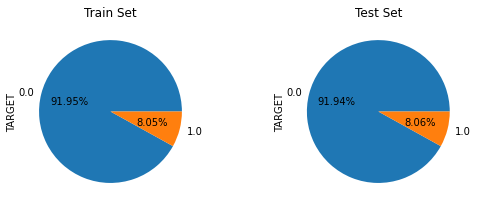

In [75]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
y_test.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Test Set')
fig.subplots_adjust(wspace=0.5)

### 4.2 Prétraitement

Nous allons prétraiter les données en :
- remplissant les valeurs manquantes (imputation)
- normalisant les features (mise à l'échelle des features).

#### 4.2.1 Imputation des valeurs manquantes

In [76]:
# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)

In [77]:
# Fit on the training data
X_train[X_train==np.inf] = np.nan
imputer.fit(X_train)

SimpleImputer(strategy='median')

In [78]:
# Transform training data

X_test[X_test==np.inf] = np.nan

X_train_preproc = imputer.transform(X_train)
X_test_preproc = imputer.transform(X_test)

#### 4.2.2 Mise à l'échèle des valeurs


In [79]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

In [80]:
# Repeat with the scaler
scaler.fit(X_train_preproc)
X_train_preproc = scaler.transform(X_train_preproc)
X_test_preproc = scaler.transform(X_test_preproc)

In [81]:
xtrain = pd.DataFrame(scaler.transform(X_train_preproc), 
                      index=X_train.index, 
                      columns=X_train.columns)

xtest = pd.DataFrame(scaler.transform(X_test_preproc), 
                     index=X_test.index, 
                     columns=X_test.columns)

### 4.3 Entrainement des modèles et choix du meilleur modèle


In [82]:
results = pd.DataFrame(columns=["Algorithm", "Balancing_method",
                                "AUC", "AUC_test", "Time"])

In [83]:
#Undersampling
rus = RandomUnderSampler(random_state=6)
xtrain_us, ytrain_us = rus.fit_resample(xtrain, y_train)

#Oversampling
smote = SMOTE(random_state=6)
xtrain_os, ytrain_os = smote.fit_resample(xtrain, y_train)

### **DummyClassifier (Baseline)**


In [84]:
dc1 = DummyClassifier(strategy="most_frequent")
dc2 = DummyClassifier(strategy="stratified")

#### Stratégie de rééquilibrage : undersampling

In [85]:
row = pf.evaluate_model(dc1, xtrain_us, ytrain_us, xtest, y_test, \
                        "Baseline", "Undersampling")

In [86]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.5,0.5,0.015622


#### Oversampling (Using SMOTE)

In [87]:
row = pf.evaluate_model(dc1, xtrain_os, ytrain_os, xtest, y_test, \
                        "Baseline", "Oversampling")

In [88]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.5,0.5,0.015622
1,Baseline,Oversampling,0.5,0.5,0.015620


#### Stratégie de rééquilibrage : class_weight='balanced'
Ce paramètre n'existant pas explicitement pour le Dummy Classifier, nous allons simuler son utilisation en modifiant la stratégie en "stratified". Le Dummy Classifier va ainsi générer des prédictions en fonction de la distribution de la valeur à prédire.

In [89]:
row = pf.evaluate_model(dc2, xtrain, y_train, xtest, y_test, \
                        "Baseline", "Balanced")

In [90]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.015622
1,Baseline,Oversampling,0.500,0.500,0.015620
2,Baseline,Balanced,0.504,0.501,0.000000


### **Régression Logistique**


In [91]:
lr = LogisticRegression()
lr_balanced = LogisticRegression(class_weight="balanced")

In [92]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 2, 10, 100]
}

gs_lr = GridSearchCV(
    lr,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_lr_balanced = GridSearchCV(
    lr_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

#### Stratégie de rééquilibrage : undersampling

In [93]:
row = pf.evaluate_model(gs_lr, xtrain_us, ytrain_us, xtest, y_test, \
                        "LogisticRegression", "Undersampling")

In [94]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.015622
1,Baseline,Oversampling,0.500,0.500,0.015620
2,Baseline,Balanced,0.504,0.501,0.000000
3,LogisticRegression,Undersampling,0.741,0.760,67.179755


#### Stratégie de rééquilibrage : oversampling

In [95]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf', LogisticRegression())
    ])

params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 2, 10, 100]
}

gs_lr_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [96]:
row = pf.evaluate_model(gs_lr_os, xtrain, y_train, xtest, y_test, \
                        "LogisticRegression", "Oversampling")

In [97]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.015622
1,Baseline,Oversampling,0.500,0.500,0.015620
2,Baseline,Balanced,0.504,0.501,0.000000
3,LogisticRegression,Undersampling,0.741,0.760,67.179755
4,LogisticRegression,Oversampling,0.733,0.754,1309.713699


#### Stratégie de rééquilibrage : class_weight='balanced'

In [98]:
row = pf.evaluate_model(gs_lr_balanced, xtrain, y_train, xtest, y_test, \
                        "LogisticRegression", "Balanced")

In [99]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.015622
1,Baseline,Oversampling,0.500,0.500,0.015620
2,Baseline,Balanced,0.504,0.501,0.000000
3,LogisticRegression,Undersampling,0.741,0.760,67.179755
4,LogisticRegression,Oversampling,0.733,0.754,1309.713699
5,LogisticRegression,Balanced,0.745,0.763,224.687680


### **RandomForestClassifier**

In [100]:
rf = RandomForestClassifier(random_state = 42)

rf_balanced = RandomForestClassifier(random_state = 42, 
                                     class_weight="balanced")

In [101]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10]
}

gs_rf = GridSearchCV(
    rf,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_rf_balanced = GridSearchCV(
    rf_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

#### Stratégie de rééquilibrage : undersampling

In [102]:
row = pf.evaluate_model(gs_rf, xtrain_us, ytrain_us, xtest, y_test, \
                        "RandomForest", "Undersampling")

In [103]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.015622
1,Baseline,Oversampling,0.500,0.500,0.015620
2,Baseline,Balanced,0.504,0.501,0.000000
3,LogisticRegression,Undersampling,0.741,0.760,67.179755
4,LogisticRegression,Oversampling,0.733,0.754,1309.713699
5,LogisticRegression,Balanced,0.745,0.763,224.687680
6,RandomForest,Undersampling,0.733,0.749,108.216721


#### Stratégie de rééquilibrage : oversampling

In [104]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf', RandomForestClassifier(random_state = 42))
    ])

params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [5, 10]
}

gs_rf_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [105]:
row = pf.evaluate_model(gs_rf_os, xtrain, y_train, xtest, y_test, \
                        "RandomForest", "Oversampling")

In [106]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.015622
1,Baseline,Oversampling,0.500,0.500,0.015620
2,Baseline,Balanced,0.504,0.501,0.000000
3,LogisticRegression,Undersampling,0.741,0.760,67.179755
4,LogisticRegression,Oversampling,0.733,0.754,1309.713699
5,LogisticRegression,Balanced,0.745,0.763,224.687680
6,RandomForest,Undersampling,0.733,0.749,108.216721
7,RandomForest,Oversampling,0.670,0.679,1600.601269


#### Stratégie de rééquilibrage : class_weight='balanced'

In [107]:
row = pf.evaluate_model(gs_rf_balanced, xtrain, y_train, xtest, y_test, \
                        "RandomForest", "Balanced")

In [108]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.015622
1,Baseline,Oversampling,0.500,0.500,0.015620
2,Baseline,Balanced,0.504,0.501,0.000000
3,LogisticRegression,Undersampling,0.741,0.760,67.179755
4,LogisticRegression,Oversampling,0.733,0.754,1309.713699
5,LogisticRegression,Balanced,0.745,0.763,224.687680
6,RandomForest,Undersampling,0.733,0.749,108.216721
7,RandomForest,Oversampling,0.670,0.679,1600.601269
8,RandomForest,Balanced,0.726,0.736,488.666188


### **Light Gradient Boosting Machine**

In [109]:
lgbm = lgb.LGBMClassifier(random_state = 42, objective = 'binary')

lgbm_balanced = lgb.LGBMClassifier(random_state = 42,
                                   objective = 'binary',
                                   class_weight = 'balanced')


In [110]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05]
}

gs_lgbm = GridSearchCV(
    lgbm,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_lgbm_balanced = GridSearchCV(
    lgbm_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

#### Stratégie de rééquilibrage : undersampling

In [111]:
row = pf.evaluate_model(gs_lgbm, xtrain_us, ytrain_us, xtest, y_test, \
                        "LGBM", "Undersampling")

In [112]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.015622
1,Baseline,Oversampling,0.500,0.500,0.015620
2,Baseline,Balanced,0.504,0.501,0.000000
3,LogisticRegression,Undersampling,0.741,0.760,67.179755
4,LogisticRegression,Oversampling,0.733,0.754,1309.713699
5,LogisticRegression,Balanced,0.745,0.763,224.687680
6,RandomForest,Undersampling,0.733,0.749,108.216721
7,RandomForest,Oversampling,0.670,0.679,1600.601269
8,RandomForest,Balanced,0.726,0.736,488.666188
9,LGBM,Undersampling,0.762,0.775,122.886276


#### Stratégie de rééquilibrage : oversampling

In [113]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf', lgb.LGBMClassifier(random_state = 42, objective = 'binary'))
    ])

params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.05]
}

gs_lgbm_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [114]:
row = pf.evaluate_model(gs_lgbm_os, xtrain, y_train, xtest, y_test, \
                        "LGBM", "Oversampling")

In [115]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.015622
1,Baseline,Oversampling,0.500,0.500,0.015620
2,Baseline,Balanced,0.504,0.501,0.000000
3,LogisticRegression,Undersampling,0.741,0.760,67.179755
4,LogisticRegression,Oversampling,0.733,0.754,1309.713699
5,LogisticRegression,Balanced,0.745,0.763,224.687680
6,RandomForest,Undersampling,0.733,0.749,108.216721
7,RandomForest,Oversampling,0.670,0.679,1600.601269
8,RandomForest,Balanced,0.726,0.736,488.666188
9,LGBM,Undersampling,0.762,0.775,122.886276


#### Stratégie de rééquilibrage : class_weight='balanced'

In [116]:
row = pf.evaluate_model(gs_lgbm_balanced, xtrain, y_train, xtest, y_test, \
                        "LGBM", "Balanced")

In [117]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.015622
1,Baseline,Oversampling,0.500,0.500,0.015620
2,Baseline,Balanced,0.504,0.501,0.000000
3,LogisticRegression,Undersampling,0.741,0.760,67.179755
4,LogisticRegression,Oversampling,0.733,0.754,1309.713699
5,LogisticRegression,Balanced,0.745,0.763,224.687680
6,RandomForest,Undersampling,0.733,0.749,108.216721
7,RandomForest,Oversampling,0.670,0.679,1600.601269
8,RandomForest,Balanced,0.726,0.736,488.666188
9,LGBM,Undersampling,0.762,0.775,122.886276


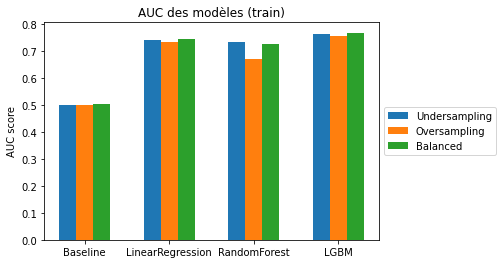

In [118]:
pf.plotComparaisonResults(results, 'AUC')

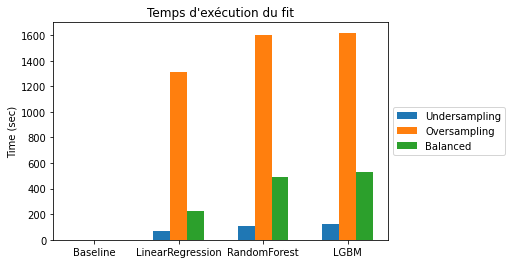

In [119]:
pf.plotComparaisonResults(results, 'Time')

### Conclusion choix du modèle

L'algorithme Light Gradient Boosting Machine associé à la stratégie de rééquilibrage consistant à indiquer "balanced" comme valeur pour "weight_class" donne les meilleurs résultats sur notre jeu de données.


In [140]:
gs_lgbm_balanced.fit(X_train, y_train) 

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced',
                                      objective='binary', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='roc_auc')

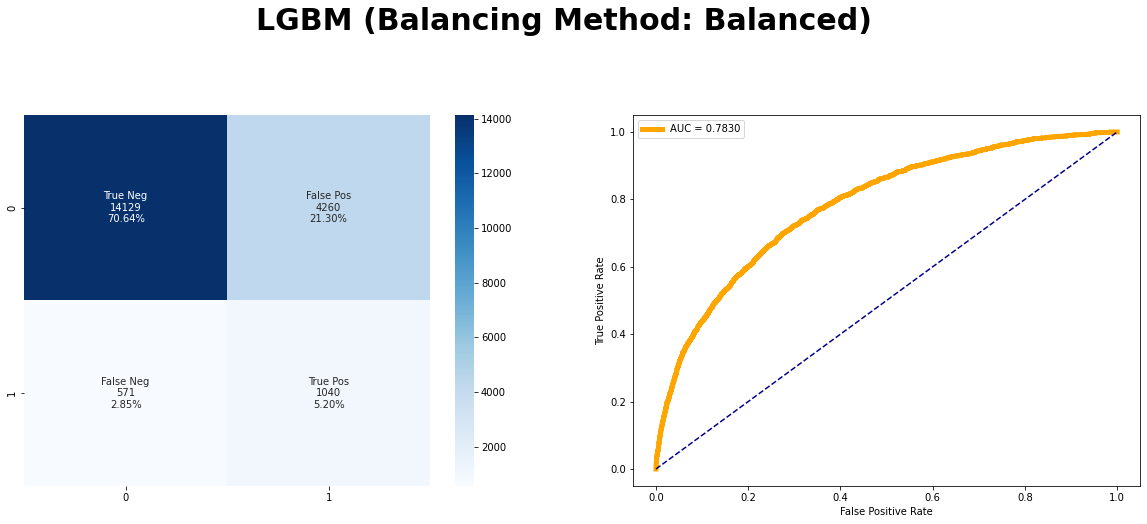

In [154]:
y_proba = gs_lgbm_balanced.predict_proba(X_test)
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)
pf.cf_matrix_roc_auc(gs_lgbm_balanced, y_test, gs_lgbm_balanced.predict(X_test), gs_lgbm_balanced.predict_proba(X_test)[:,1], roc_auc, "LGBM (Balancing Method: Balanced)")

___
### 4.4 Optimisation du modèle d'un point de vue métier (fonction coût métier)

- La problématique « métier » est de prendre en compte qu'un faux positif (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n'a pas le même coût qu'un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est en effet 10 fois plus coûteux qu'un faux positif.

- Nous allons définir une fonction métier adaptée au projet qui permet d'attribuer plus de poids à la minimisation des FN.

- Ainsi nous allons à nouveau effectuer une nouvelle recherche des hyper-paramètres via HyperOpt se basant sur la fonction métier proposée, de cette façon, ils seront choisis de sorte à minimiser la perte pour l'entreprise.

In [142]:
def custom_score(y_true, y_pred) :
    '''
        Cost function to minimize the risk for the
        loaning firm.
    
        Parameters
        --------
        - y_true : pandas dataframe
                   The true values of the target
        - y_pred : pandas dataframe
                   The predicted values for the target
            
        Returns
        --------
        - score : float
                  The score for the prediction
    '''

    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    N = TN + FP    # total negatives cases
    P = TP + FN    # total positives cases
    
    # Setting the bank's gain and loss for each case
    FN_value = -10   # The loan is granted but the customer defaults : the bank loses money (Type-II Error)
    TN_value = 1     # The loan is reimbursed : the bank makes money
    TP_value = 0     # The loan is (rightly) refused : the bank neither wins nor loses money
    FP_value = -1    # Loan is refused by mistake : the bank loses money it could have made, 
                     # but does not actually lose any money (Type-I Error)

    # calculate total gains
    gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    
    # best score : all observations are correctly predicted
    best = N*TN_value + P*TP_value 

    # baseline : all observations are predicted = 0
    baseline = N*TN_value + P*FN_value 
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    
    return score


In [143]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}

In [144]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [145]:
%%time
best = fmin(fn=objective, space=space, max_evals=10, algo=tpe.suggest)

100%|██████████| 10/10 [27:48<00:00, 166.89s/trial, best loss: 0.9745731139397703]
Wall time: 27min 48s


In [146]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    class_weight = 'balanced',)

lgbm.fit(X_train, y_train)


Wall time: 47.8 s


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8625450372680663,
               learning_rate=0.028236173047750855, max_depth=5,
               n_estimators=500, reg_lambda=12.172871202131482,
               subsample=0.8872433081152037)

In [149]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.786163


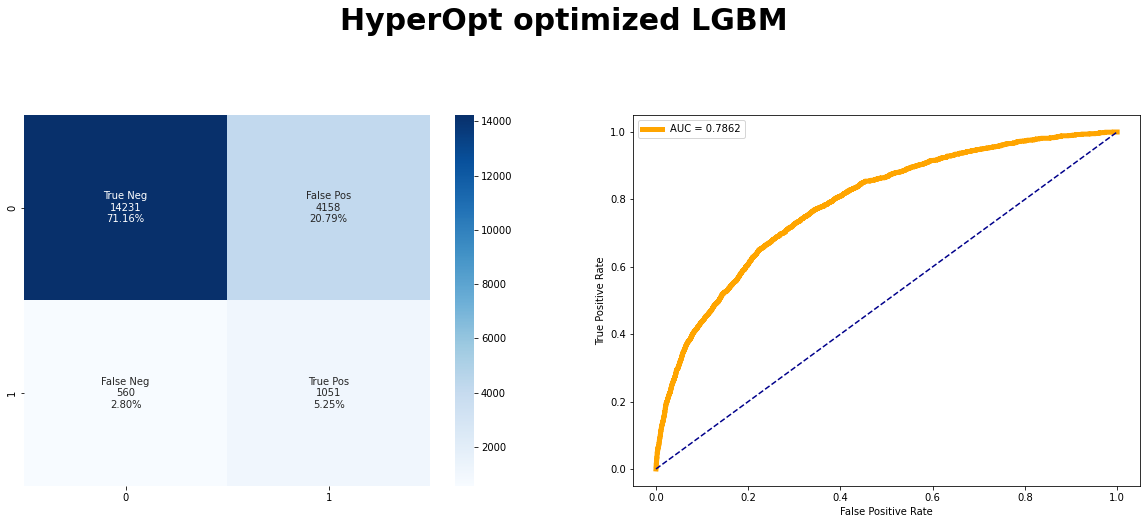

In [148]:
pf.cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test), lgbm.predict_proba(X_test)[:,1],roc_auc, "HyperOpt optimized LGBM")

### Conclusion optimisation métier

- On a réussi à optimiser le modèle LGBM sélectionné d'un point de vue métier avec HyperOpt. 
- On a un meilleur score AUC et une diminution du nombre de FN sur le jeu de test.

___
### 4.5 Interprétabilité

Nous allons utiliser la librairie SHAP pour calculer la feature importance globale afin de connaitre d'une manière générale les principales features qui contribuent à l'élaboration du modèle.  

**features importance des prédictions faites par le modèle sur xtest**

In [150]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_importance)

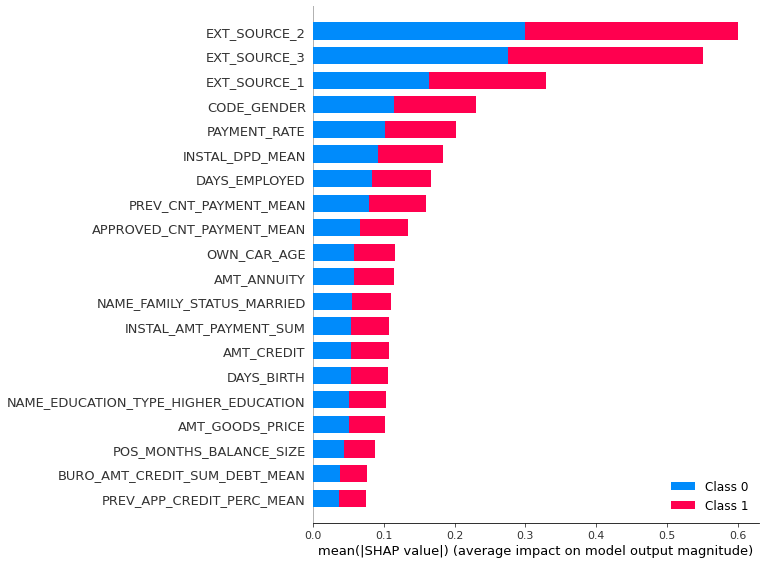

In [151]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

100%|===================| 79971/80000 [31:22<00:00]        

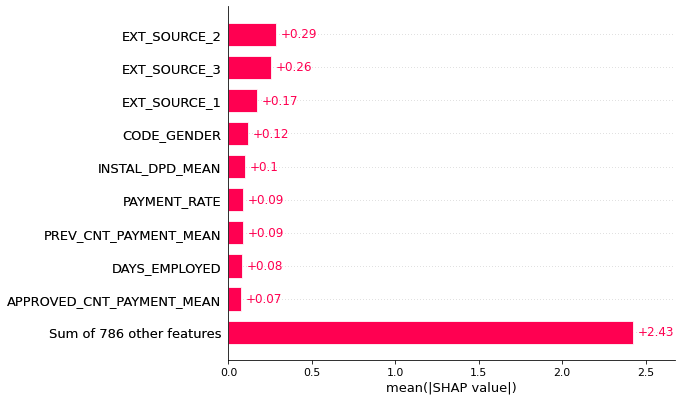

In [152]:
# compute SHAP values

explainer = shap.Explainer(lgbm, X_train)
shap_values = explainer(X_train, check_additivity=False)
shap.plots.bar(shap_values)

___
### 4.6 Sauvegardes

In [153]:
#Sauvegarde du modèle
pickle.dump(lgbm, open("./LGBMClassifier.pkl", "wb"))

In [156]:
#Sauvegarde des fichiers au format parquet

application_train = pd.read_csv(PATH+"/application_train.csv")
application_test = pd.read_csv(PATH+"/application_test.csv")

application_train.to_parquet(PATH+'/application_train.parquet')
application_test.to_parquet(PATH+'/application_test.parquet')
test_df.to_parquet(PATH+'/test_df.parquet')